### 1. Load the data

In [1]:
# necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import plotly.express as px
from plotly.subplots import make_subplots
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# dark grid, colorblind
sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [3]:
# load the data
df = pd.read_csv('../../data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 2. EDA (Exploratory Data Analysis) and Data Visualization

Let's check how age, sex, bmi, children, smoker, region influence the charges.

#### 2.1 Distribution of charges, with respect to smokers/non-smokers

In [4]:
fig = make_subplots(rows=1, cols=4, subplot_titles=('Distribution of charges', 'Distribution of charges for smokers', 'Distribution of charges for non-smokers'))
fig.add_trace(px.histogram(df, x='charges', nbins=50, color_discrete_sequence=['green']).data[0], row=1, col=1)
fig.add_trace(px.histogram(df[df['smoker'] == 'yes'], x='charges', nbins=50, color_discrete_sequence=['red']).data[0], row=1, col=2)
fig.add_trace(px.histogram(df[df['smoker'] == 'no'], x='charges', nbins=50, color_discrete_sequence=['blue']).data[0], row=1, col=3)
# add boxplots
fig.add_trace(px.box(df, y='smoker', x='charges', color_discrete_sequence=['red', 'blue']).data[0], row=1, col=4)
fig.update_layout(showlegend=False)
# x axes range from 0 to the highest charge
fig.update_xaxes(range=[0, df['charges'].max()], row=1, col=1)
fig.update_xaxes(range=[0, df['charges'].max()], row=1, col=2)
fig.update_xaxes(range=[0, df['charges'].max()], row=1, col=3)
fig.show()

```
Non-smokers tend to have lower charges than smokers. Kind of self-explanatory!
```

#### 2.2 How does sex affect the charges?

In [6]:
fig = px.box(df, x='sex', y='charges', color='sex', color_discrete_sequence=['red', 'blue'])
fig.update_layout(showlegend=False)
fig.show()

```
Seems like gender doesn't play much of a role in determining the charges.
```

#### 2.3 Relationship between age and charges

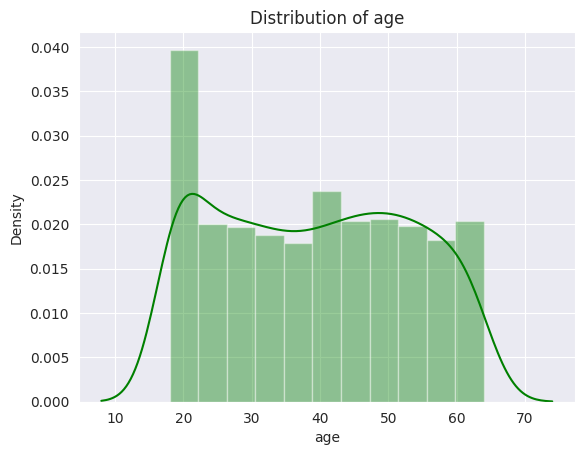

In [105]:
# distribution of age
sns.distplot(df['age'], color='green')
plt.title('Distribution of age')
plt.show()

In [106]:
# scatter plot of charges vs age
fig = px.scatter(df, x='age', y='charges', color='smoker', trendline='ols')
fig.show()

```
There is a positive correlation between age and charges, for smokers and non-smokers.
```

#### 2.4 BMI (Body Mass Index)

In [107]:
fig = px.scatter(df, x='bmi', y='charges', color='smoker', trendline='ols')
fig.show()

There us a strong correlation between BMI and charges for smokers. For non-smokers, the correlation is not as strong.

#### 2.5 Region

In [108]:
# impact of region on charges
fig = px.box(df, x='region', y='charges', color='region')
fig.update_layout(showlegend=False)
fig.show()

```
There is no significant difference in charges based on region.
```

#### 2.6 Children

In [109]:
# impact of children on charges
fig = px.box(df, x='children', y='charges', color='children')
fig.update_layout(showlegend=False)
fig.show()

```
No significant difference in charges based on number of children.
```

### 3. Data Preprocessing and Feature Engineering

In [110]:
# let's make a copy of the original dataframe
df_copy = df.copy()
df_copy.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [111]:
# we need to convert categorical columns ("sex", "smoker", "region") to numerical columns
df_copy['sex'] = df_copy['sex'].map({'male':0, 'female':1})
df_copy['smoker'] = df_copy['smoker'].map({'no':0, 'yes':1})
df_copy['region'] = df_copy['region'].map({'northeast':0, 'northwest':1, 'southeast':2, 'southwest':3})

In [112]:
# let's check the dataframe again
df_copy.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.90,0,1,3,16884.9240
1,18,0,33.77,1,0,2,1725.5523
2,28,0,33.00,3,0,2,4449.4620


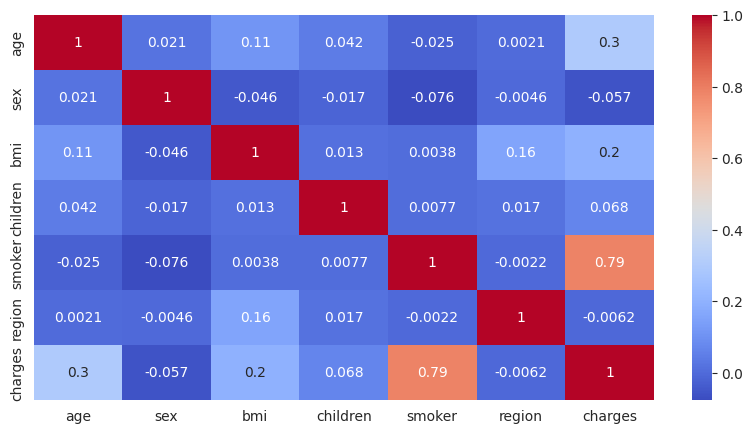

In [113]:
# let's check the correlation between the features
plt.figure(figsize=(10, 5))
sns.heatmap(df_copy.corr(), annot=True, cmap='coolwarm')
plt.show()

As we have seen from the EDA section, sex, children, and region do not influence the charges much. Therefore, they are not good predictors for our model. However, we will keep them for now, and see how our model performs.

In [114]:
# train test split
X = df_copy.drop('charges', axis=1).values
y = df_copy['charges'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

We will employ tree-based models, we do not need to scale the data.

### 4. Model Training and Evaluation

In [116]:
# create the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, seed=42)

# train the model
xgb_model.fit(X_train, y_train)

# make predictions
y_pred = xgb_model.predict(X_test)

# check the performance of the model
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 score:', r2_score(y_test, y_pred))

RMSE: 4688.933170665864
R2 score: 0.856201868697234


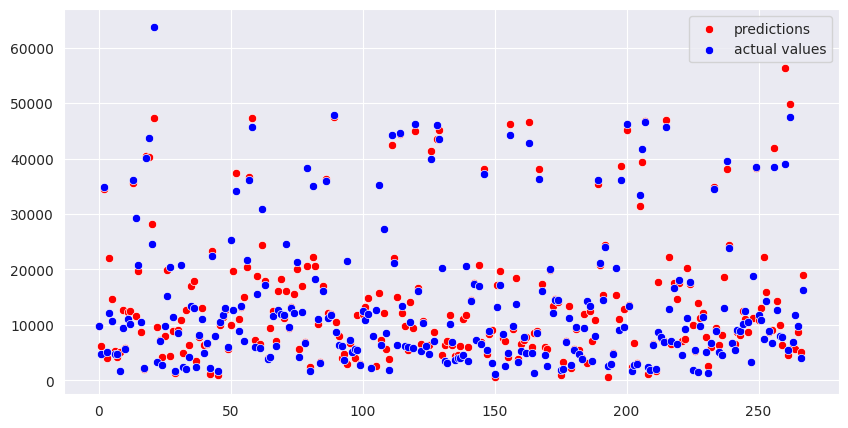

In [126]:
# plot the predictions vs actual values
plt.figure(figsize=(10, 5))
sns.scatterplot(y_pred, color='red', label='predictions')
sns.scatterplot(y_test, color='blue', label='actual values')
plt.legend()
plt.show()

Not a bad result for a first try! We can try to improve the model by tuning the hyperparameters, and employing other tree-based models, and see which one performs the best.